# Customer Segmentation Using RFM Analysis
This notebook performs customer segmentation using the **Online Retail Dataset**.

### Objectives:
- Clean and preprocess the dataset
- Compute **RFM (Recency, Frequency, Monetary)** values
- Assign RFM scores and customer segments
- Visualize the distribution of customer groups
- Provide marketing suggestions for each group


## Import Required Libraries

In [12]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")


## Load Dataset

In [2]:

df = pd.read_csv("C:/Users/HP/Downloads/Online Retail.csv", encoding='ISO-8859-1')

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2010 8:26,3.39,17850.0,United Kingdom


## Data Cleaning
- Remove missing customer IDs
- Remove negative or zero values in Quantity/UnitPrice
- Create a `TotalPrice` column
- Convert InvoiceDate to datetime

In [ ]:
df = df.dropna(subset=['CustomerID'])
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], dayfirst=True, errors='coerce')

print("Cleaned dataset shape:", df.shape)
df.head()


Cleaned dataset shape: (397884, 9)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


## Compute RFM Metrics
- **Recency**: Days since last purchase
- **Frequency**: Number of transactions
- **Monetary**: Total spending

In [6]:

reference_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})

rfm.rename(columns={'InvoiceDate': 'Recency',
                    'InvoiceNo': 'Frequency',
                    'TotalPrice': 'Monetary'}, inplace=True)

rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


## Assign RFM Scores (1–5)
Divide customers into 5 groups for each R, F, M metric using `qcut`. Then combine them into an overall score.

In [7]:

rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method="first"), 5, labels=[1,2,3,4,5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score'] = rfm[['R_Score','F_Score','M_Score']].astype(int).sum(axis=1)

rfm.head()


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,5,115,7
12347.0,2,7,4310.00,5,5,5,555,15
12348.0,75,4,1797.24,2,4,4,244,10
12349.0,19,1,1757.55,4,1,4,414,9
12350.0,310,1,334.40,1,1,2,112,4


## Define Customer Segments
Classify customers based on their RFM scores into groups such as *Champions*, *Loyal Customers*, etc.

In [8]:
def segment_customer(score):
    if score >= 12:
        return 'Champions'
    elif score >= 9:
        return 'Loyal Customers'
    elif score >= 6:
        return 'Potential Loyalist'
    else:
        return 'At Risk / Inactive'

rfm['Segment'] = rfm['RFM_Score'].apply(segment_customer)
rfm.head()


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score,Segment
CustomerID,,,,,,,,,
12346.0,326,1,77183.60,1,1,5,115,7,Potential Loyalist
12347.0,2,7,4310.00,5,5,5,555,15,Champions
12348.0,75,4,1797.24,2,4,4,244,10,Loyal Customers
12349.0,19,1,1757.55,4,1,4,414,9,Loyal Customers
12350.0,310,1,334.40,1,1,2,112,4,At Risk / Inactive


## Visualization
- Bar chart of customer segments
- Heatmap of Recency vs Frequency with average Monetary value

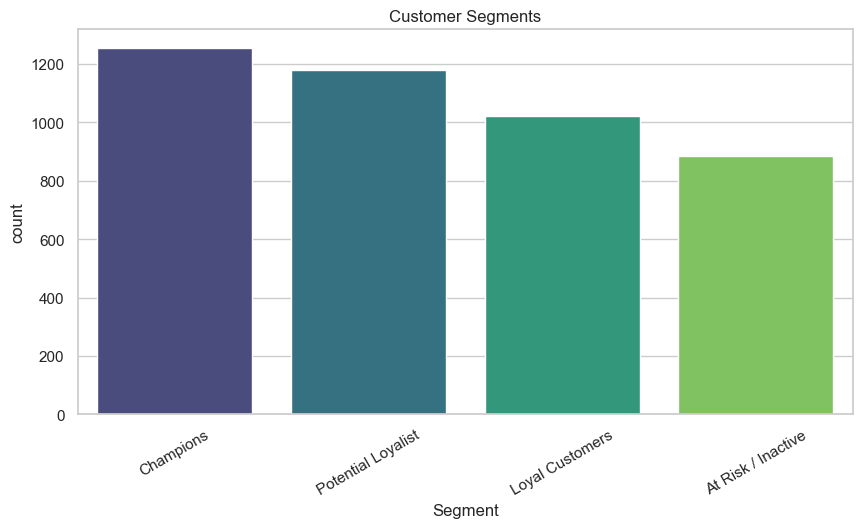

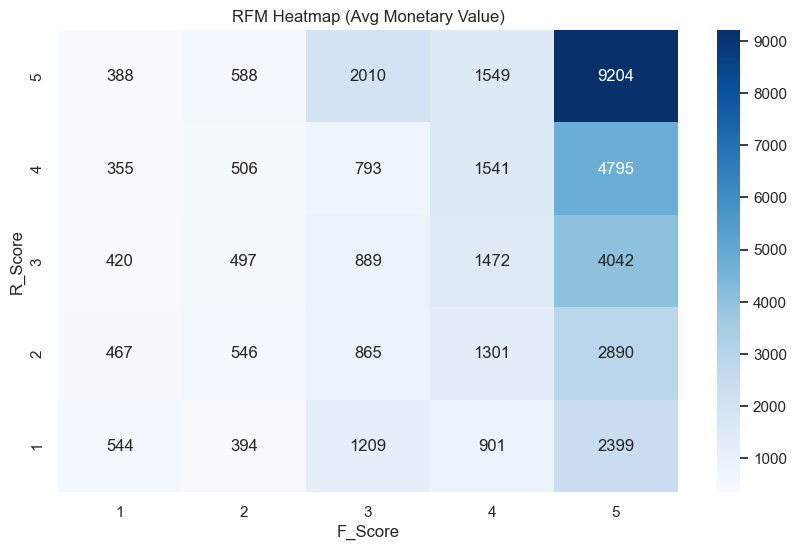

In [13]:
plt.figure(figsize=(10,5))
sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index, palette="viridis")
plt.title("Customer Segments")
plt.xticks(rotation=30)
plt.show()

rfm_heatmap = rfm.groupby(['R_Score','F_Score'])['Monetary'].mean().unstack()
plt.figure(figsize=(10,6))
sns.heatmap(rfm_heatmap, cmap="Blues", annot=True, fmt=".0f")
plt.title("RFM Heatmap (Avg Monetary Value)")
plt.show()


## Segment Summary
Calculate average RFM metrics and customer counts for each segment.

In [14]:

segment_summary = rfm.groupby('Segment').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':'mean',
    'RFM_Score':'mean',
    'RFM_Segment':'count'
}).rename(columns={'RFM_Segment':'CustomerCount'}).sort_values('CustomerCount', ascending=False)

segment_summary


,Recency,Frequency,Monetary,RFM_Score,CustomerCount
Segment,,,,,
Champions,19.237450,9.949004,5443.466518,13.537052,1255
Potential Loyalist,103.077250,1.624788,581.015894,6.963497,1178
Loyal Customers,55.953033,3.139922,1166.336792,10.009785,1022
At Risk / Inactive,224.995470,1.045300,230.378822,4.175538,883


## Marketing Suggestions
Based on segment behavior, marketing strategies.

In [15]:

marketing_ideas = {
    "Champions": "Reward them with loyalty programs, VIP offers.",
    "Loyal Customers": "Offer subscription plans, exclusive discounts.",
    "Potential Loyalist": "Send personalized recommendations, upsell offers.",
    "At Risk / Inactive": "Re-engage with win-back campaigns, discount codes."
}

print("\n--- Marketing Suggestions ---")
for seg, idea in marketing_ideas.items():
    print(f"{seg}: {idea}")



--- Marketing Suggestions ---
Champions: Reward them with loyalty programs, VIP offers.
Loyal Customers: Offer subscription plans, exclusive discounts.
Potential Loyalist: Send personalized recommendations, upsell offers.
At Risk / Inactive: Re-engage with win-back campaigns, discount codes.
